In [1]:
from climada.util.api_client import Client
from climada_petals.engine import SupplyChain
from climada.entity import ImpfSetTropCyclone, ImpactFuncSet
from climada.engine.impact_calc import ImpactCalc
from climada.hazard import Hazard
import datetime
import numpy as np
client = Client()

# calculate impacts

In [2]:
# we get probabilistic tc for WP and NA
tc_wp_prob = client.get_hazard('tropical_cyclone', name='tropical_cyclone_10synth_tracks_150arcsec_genesis_WP_1980_2020')
tc_na_prob = client.get_hazard('tropical_cyclone', name='tropical_cyclone_10synth_tracks_150arcsec_genesis_NA_1980_2020')

In [3]:
assets = client.get_litpop()

/Users/szelie/miniconda3/envs/climada_env/lib/python3.9/pickle.py:1717: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  setstate(state)


In [4]:
def get_impf_id(cnt):
    for basin, iso_list in ImpfSetTropCyclone.get_countries_per_region()[2].items():
        for iso in iso_list:
            if iso == cnt:
                return basin, ImpfSetTropCyclone.get_countries_per_region()[1][basin]
            
impf_TC = ImpfSetTropCyclone.from_calibrated_regional_ImpfSet()

assets.gdf['impf_TC'] = 1

for cnt in np.unique(assets.gdf.region_id):
    assets.gdf.loc[assets.gdf['region_id']==cnt, 'impf_TC'] = get_impf_id(int(cnt))[1]

# impact calculation, already selecting the date
imp_calc = ImpactCalc(assets, impf_TC, tc_na_prob)
direct_impact_na = imp_calc.impact(save_mat=True)  

imp_calc = ImpactCalc(assets, impf_TC, tc_wp_prob)
direct_impact_wp = imp_calc.impact(save_mat=True) 

2023-06-21 23:06:22,742 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 6368468 coordinates.
2023-06-21 23:06:43,642 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 7549716 coordinates.
2023-06-21 23:06:44,026 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 7249 coordinates.


#  We here recreate years of impacts by sampling a number of impact per year based on a poisson distribution. The day and month of the event are kept, we could consider changing those but it requires some assumptions. 

In [73]:
import climada.util.dates_times as u_dt

def year_date_event_in_sample(years, dates, sampling_vec):
    """
    Change the year for the sampled events

    Parameters
    ----------
    years : list[int]
        Years of sampled events (length equal to lenght of sampling_vec)
    dates : list[dates]
        List of dates in ordinal format for the whole event set
    sampling_vec : list[np.array]
        Array of ids (row index) of selected events per year.

    Raises
    ------
    ValueError
        length of years must equal length of sampling_vec

    Returns
    -------
    list[dates]
        List with dates in ordinal format of the sampled events.

    """
    if len(years) != len(sampling_vec):
        raise ValueError("The number of years is different from the length" +
                         "of the sampling vector")
    def change_year(old_date, year):
        old_date = u_dt.date_to_str(old_date)
        if old_date[5:7] == '02' and old_date[8:10] == '29':
            old_date = old_date.replace('29', '28')
        new_date = old_date.replace(old_date[0:4], str(year))
        return u_dt.str_to_date(new_date)

    return [
        change_year(date, year)
        for year, events in zip(years, sampling_vec)
        for date in np.array(dates)[events]
        ]

In [71]:
from climada.util import yearsets
def make_yearset(impact_dict, n_years):
    """
    Parameters
    ----------
    impact_dict : dict of Impact
        dictionary of impacts
    n_years : number of years

    Returns
    -------
    imp : dict
        
    """
    years = np.arange(1, n_years+1)
    yearset_dict = {}
    for impact in impact_dict: # we do this per basin as the frequencies are different
        lam = np.sum(impact_dict[impact].frequency)
        lam = np.round(lam, 10) 
        events_per_year = yearsets.sample_from_poisson(len(years), lam) # number of events to pick for each year
        sampling_vect = yearsets.sample_events(events_per_year, impact_dict[impact].frequency) # vector containing the the event id per year
        yearset = copy.deepcopy(impact_dict[impact]) # new impact object
        yearset.date = year_date_event_in_sample(years,impact_dict[impact].date,sampling_vect)
        sampling_vect = np.concatenate(sampling_vect)
        yearset.event_name = list(np.array(impact_dict[impact].event_name)[sampling_vect])
        yearset.at_event = impact_dict[impact].at_event[sampling_vect]
        yearset.event_id = np.arange(1, len(yearset.event_name)+1)
        yearset.frequency = np.ones(len(yearset.event_id))/n_years

        yearset.imp_mat = impact_dict[impact].imp_mat[sampling_vect, :]
        yearset_dict[impact] = yearset
    return yearset_dict

In [74]:
from climada.util import yearsets, coordinates
import pycountry

# create n years of impacts by sampling events based on the expected number of events. This is
# done per basin
def yearset_impact(direct_impact_wp, direct_impact_na, countries_num, n_years):
    
    impact_dict = {'wp':direct_impact_wp, 'na':direct_impact_na}
    ys = make_yearset(impact_dict, n_years) # we get n_years for each basin separatly
    imp = Impact()
    imp.frequency = np.hstack([ys['wp'].frequency, ys['na'].frequency])
    imp.date = np.hstack([ys['wp'].date, ys['na'].date])
    imp.event_name = np.hstack([ys['wp'].event_name, ys['na'].event_name])

    imp.event_id = np.hstack([ys['wp'].event_id, (ys['na'].event_id+np.max(ys['wp'].event_id))])
    imp.coord_exp = direct_impact_wp.coord_exp
    imp.imp_mat = sparse.vstack([ys['wp'].imp_mat,ys['na'].imp_mat])

    
    imp.at_event, imp.eai_exp, imp.aai_agg = ImpactCalc.risk_metrics(imp.imp_mat, imp.frequency)
    imp = imp.select(event_ids = imp.event_id[imp.at_event>1e8])
    imp.tag = impact_dict['wp'].tag
    country_matrices = {country: np.array([imp.imp_mat[:, countries_num == countries[country]].sum(axis=1).flatten()])
                     for country in countries}
    
    years = [datetime.date.fromordinal(date).year for date in imp.date]
    country_year_impact = {year: {country: country_matrices[country][0][0][years==year].sum()\
                              for country in countries} for year in np.unique(years)}
  
    n_countries_per_year = {year:np.sum([np.array(list(country_year_impact[year].values()))>1e8]) for year in years}
    

    return (imp, country_year_impact, n_countries_per_year, imp.aai_agg)



In [7]:
from climada.util import yearsets, coordinates
lat = np.array([lat for lat,lon in direct_impact_wp.coord_exp])
lon = np.array([lon for lat,lon in direct_impact_wp.coord_exp])
countries_num = coordinates.get_country_code(lat, lon)
countries_num = np.array([format(num, '03d') for num in countries_num])


In [ ]:
from scipy import sparse
from climada.engine import Impact
import copy
countries = ['USA', 'TWN', 'JPN','CHN','MEX'] # we could chose more countries
countries = {country:pycountry.countries.lookup(country).numeric for country in countries}

# 100 time 5 years, date start at year 1
yearsets_samples = [yearset_impact(direct_impact_wp, direct_impact_na, countries_num, n_years=5) for n in range(0,100)]

# The following cells are to select samples that cause most impacts/affect most countries. We can ignore it for now


In [84]:
n_countries_score = [np.sum(list(yearsets_samples[n][2].values())) for n in range(len(yearsets_samples))]

aai = [yearsets_samples[n][3] for n in range(len(yearsets_samples))]

In [86]:
#5 years with most damages:
picked_yearset1 = yearsets_samples[np.argsort(aai)[0]][0]
picked_yearset1.tag = direct_impact_wp.tag #we miss the tag if we want to save it

#5 years with most countries affected:

picked_yearset2 = yearsets_samples[np.argsort(n_countries_score)[0]][0]
picked_yearset2.tag = direct_impact_wp.tag #we miss the tag if we want to save it
#yearsets_samples[17][0].write_csv("yearset_wp_na_combined.csv") #to save

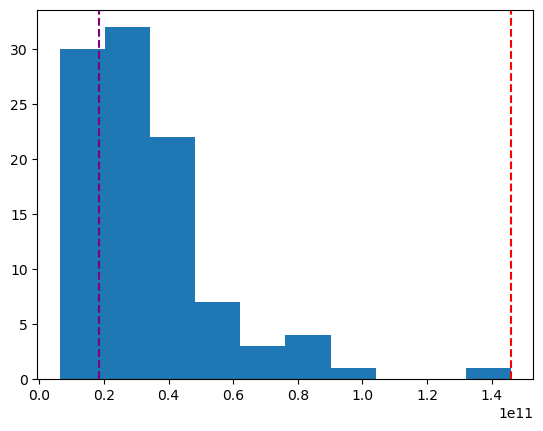

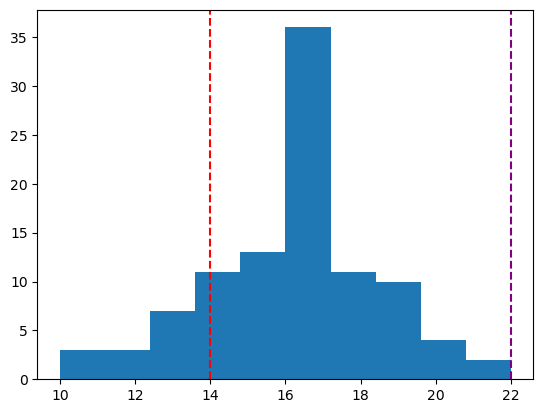

In [88]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.hist(aai)
plt.axvline(x=np.max(aai), color='red', linestyle='--')# yearset with most total damage

plt.axvline(x=aai[np.argsort(n_countries_score)[0]], color='purple', linestyle='--') # yearset with most countries affected

fig,ax = plt.subplots()

ax.hist(n_countries_score)
plt.axvline(x=n_countries_score[np.argsort(aai)[0]], color='red', linestyle='--') 
plt.axvline(x=np.max(n_countries_score), color='purple', linestyle='--')# yearset with most total damage


# save and read impact files, we save 10 samples of 5 years

In [62]:
import os

output_directory = "/Users/szelie/Library/CloudStorage/OneDrive-ETHZurich/data/supply_chain/direct_impacts_yearsets/"

for n, sample in enumerate(yearsets_samples[0:10]):
    sample_red = sample[0].select(coord_exp=sample[0].coord_exp[sample[0].eai_exp>0])
    sample_red = sample_red.select(event_ids=sample_red.event_id[sample_red.at_event>1e6])
    output_csv_path = os.path.join(output_directory, f"sample_{n}_5y_impact_na_wp.csv")
    output_npz_path = os.path.join(output_directory, f"sample_{n}_5y_impact_na_wp.npz")
    sample_red.write_csv(output_csv_path)
    sample_red.write_sparse_csr(output_npz_path)

2023-06-22 12:24:54,540 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2023-06-22 12:25:03,338 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2023-06-22 12:25:12,258 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2023-06-22 12:25:21,395 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2023-06-22 12:25:30,110 - climada.engine.impact - WARNING - The 

In [89]:
import os
import pandas as pd
from scipy.sparse import csr_matrix

input_directory = "/Users/szelie/Library/CloudStorage/OneDrive-ETHZurich/data/supply_chain/direct_impacts_yearsets/"

# Create an empty list to store the Impact objects
impacts = []

# Loop through the CSV files in the input directory
for n in range(10):
    input_csv_path = os.path.join(input_directory, f"sample_{n}_5y_impact_na_wp.csv")
    
    impact = Impact.from_csv(input_csv_path)
    
    # Read the sparse CSR matrix from a file
    sparse_csr_path = os.path.join(input_directory, f"sample_{n}_5y_impact_na_wp.npz")
    impact.imp_mat = Impact.read_sparse_csr(sparse_csr_path)
    
    # Append the Impact object to the list
    impacts.append(impact)

2023-06-22 15:23:08,463 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2023-06-22 15:23:08,608 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold


/Users/szelie/python_projects/climada_python/climada/engine/impact.py:1102: DtypeWarning: Columns (0,1,2,7,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  imp_df = pd.read_csv(file_name)
/Users/szelie/python_projects/climada_python/climada/engine/impact.py:1102: DtypeWarning: Columns (0,1,2,7,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  imp_df = pd.read_csv(file_name)


2023-06-22 15:23:08,702 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2023-06-22 15:23:08,773 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2023-06-22 15:23:08,865 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold


/Users/szelie/python_projects/climada_python/climada/engine/impact.py:1102: DtypeWarning: Columns (0,1,2,7,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  imp_df = pd.read_csv(file_name)
/Users/szelie/python_projects/climada_python/climada/engine/impact.py:1102: DtypeWarning: Columns (0,1,2,7,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  imp_df = pd.read_csv(file_name)
/Users/szelie/python_projects/climada_python/climada/engine/impact.py:1102: DtypeWarning: Columns (0,1,2,7,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  imp_df = pd.read_csv(file_name)


2023-06-22 15:23:08,960 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2023-06-22 15:23:09,030 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2023-06-22 15:23:09,102 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold


/Users/szelie/python_projects/climada_python/climada/engine/impact.py:1102: DtypeWarning: Columns (0,1,2,7,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  imp_df = pd.read_csv(file_name)
/Users/szelie/python_projects/climada_python/climada/engine/impact.py:1102: DtypeWarning: Columns (0,1,2,7,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  imp_df = pd.read_csv(file_name)
/Users/szelie/python_projects/climada_python/climada/engine/impact.py:1102: DtypeWarning: Columns (0,1,2,7,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  imp_df = pd.read_csv(file_name)


2023-06-22 15:23:09,182 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold
2023-06-22 15:23:09,289 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold


/Users/szelie/python_projects/climada_python/climada/engine/impact.py:1102: DtypeWarning: Columns (0,1,2,7,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  imp_df = pd.read_csv(file_name)
/Users/szelie/python_projects/climada_python/climada/engine/impact.py:1102: DtypeWarning: Columns (0,1,2,7,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  imp_df = pd.read_csv(file_name)
